This notebook is the result of __Ludovic Sterlin and Remi Grand__ work on 2020 exam of the class "FSD311-SDD-AML-Lin", given by Mr RISSER

# EXAMEN 2020
Cet examen est composé de deux exercices. 

Les réponses seront données dans un notebook et l'examen sera fait soit seul soit en binome. 

In [5]:
# make general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from scipy import stats
from statistics import mean

# Exercice 1 : 
Nous souhaitons maintenant evaluer si un nouveau traitement à un effet significatif sur l'__efficacite__ d'un moteur en fonction de son __age__.

## QUESTION 1.1 : 
Lisez le fichier `Observations_2.csv` qui contient les donnees, traitez les et representez les avec :
- 'Age' en abscisse
- 'Efficiency' en ordonnee
- Les observations avec le traitement standard (Standard) en bleu
- Les observations avec le nouveau traitement (Tested) en rouge.

A la vue du graphe, vous semble-t-il y avoir un effet ?

In [6]:
# Reading of the csv file
dataframe2=pd.read_csv("./data/Observations_2.csv",sep=' ')
dataframe2.head(1)

,Treatment,Age,Efficiency
0,Standard,3.9479,3.2224


In [7]:
dataframe2.describe()

,Age,Efficiency
count,70.000000,70.000000
mean,5.095016,3.882837
std,2.837539,1.320810
min,0.402640,1.099200
25%,2.718500,3.238025
50%,4.891650,3.867900
75%,7.603675,4.748475
max,9.974900,6.731900


In [8]:
# General statistics on each group of data
dataframe2.groupby("Treatment").describe()

Age                                                           \
          count      mean       std      min      25%      50%       75%   
Treatment                                                                  
Standard   50.0  5.285968  2.745240  0.40264  3.45875  5.53165  7.627775   
Tested     20.0  4.617638  3.077085  0.80066  2.07540  3.75350  6.873100   

                  Efficiency                                                 \
              max      count      mean       std     min       25%      50%   
Treatment                                                                     
Standard   9.8588       50.0  3.749378  1.397119  1.0992  2.766100  3.79060   
Tested     9.9749       20.0  4.216485  1.066503  2.1778  3.645375  4.03055   

                             
                75%     max  
Treatment                    
Standard   4.748475  5.9266  
Tested     4.717200  6.7319

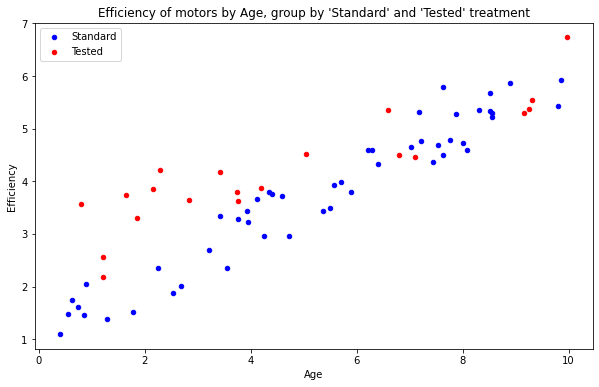

In [9]:
# Plot the observations representing Efficiency of motors by Age, group by 'Standard' and 'Tested' treatment
fig, ax = plt.subplots(figsize=(10,6))
for key, group in dataframe2.groupby("Treatment"):
    group.plot(ax=ax, kind='scatter', x='Age',y='Efficiency', 
    title="Efficiency of motors by Age, group by 'Standard' and 'Tested' treatment", label=key, 
    color='r' if key=='Tested' else 'b')
plt.show()

### A la vue du graphe, vous semble-t-il y avoir un effet ?
En observant le graphique nous pouvons suggérer que le nouveau traitement rend les moteurs plus efficaces lors de leurs premières années d'utilistation, nottament de facon sigificative pendant les 5 premières années. 

Cependant il semble aussi provoquer une détérioration prématurée du moteur comparé au traitement standard, en effet on peut voir qu'en moyenne la tendance de l'efficacité à croître avec l'âge est plus faible pour le nouveau traitement que pour le standard.

Il faut tout de même rester prudent car nous avons peu de données surtout sur le nouveau traitement ("Tested"), uniquement 20 points de données comparé à 50 pour le traitement standard ("Standard").

## QUESTION 1.2 : 
On supposera qu'il existe une relation lineaire entre l'age du moteur et son niveau d'efficacite a un bruit Gaussien pres. Utilisez un modele de type regression lineaire pour mettre en lien les données. 

Utilisez ensuite un test statistique pour evaluer si l'impact du traitement est significatif.

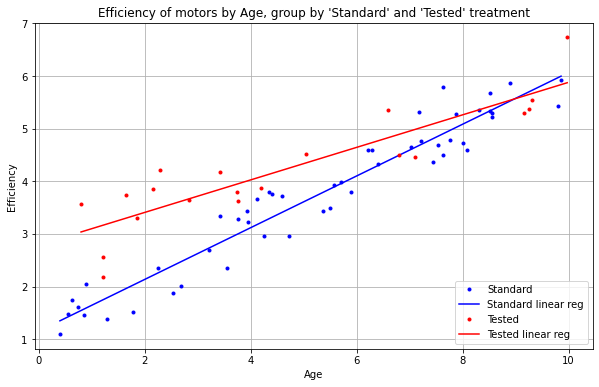

In [10]:
# Seperating data in two dataframe
Standard = dataframe2.loc[dataframe2["Treatment"] == "Standard"].sort_values(by='Age')
Tested = dataframe2.loc[dataframe2["Treatment"] == "Tested"].sort_values(by='Age')

# making linear regression on each one of them
lrs = LinearRegression()
lrs.fit(Standard.Age[:, np.newaxis], Standard.Efficiency)

lrt = LinearRegression()
lrt.fit(Tested.Age[:, np.newaxis], Tested.Efficiency)

# Plotting the data in one same graph
fig = plt.figure(figsize=(10,6))

plt.plot(Standard.Age, Standard.Efficiency, 'b.')
plt.plot(Standard.Age, lrs.predict(Standard.Age[:, np.newaxis]), 'b-')

plt.plot(Tested.Age, Tested.Efficiency, 'r.')
plt.plot(Tested.Age, lrt.predict(Tested.Age[:, np.newaxis]), 'r-')

plt.xlabel('Age')
plt.ylabel('Efficiency')
plt.legend(['Standard', 'Standard linear reg', 'Tested', 'Tested linear reg'], loc='lower right')
plt.title("Efficiency of motors by Age, group by 'Standard' and 'Tested' treatment")
plt.grid()
plt.show()

### Utilisez ensuite un test statistique pour evaluer si l'impact du traitement est significatif.

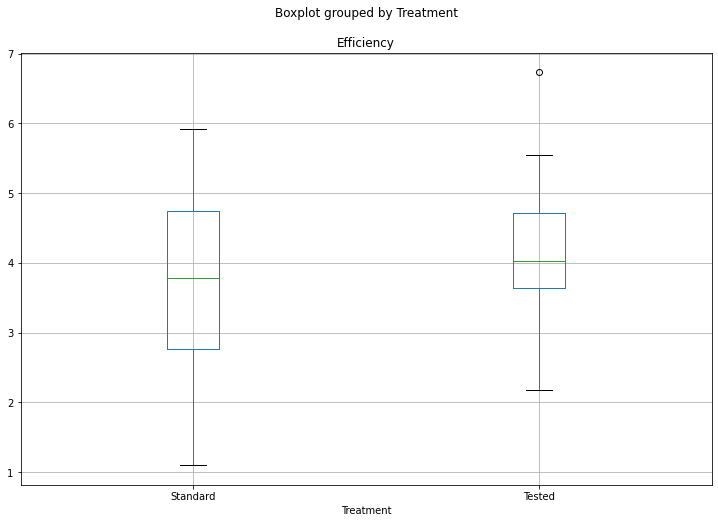

In [11]:
dataframe2.boxplot('Efficiency', by='Treatment', figsize=(12, 8))
plt.show()

In [12]:
def fisher(data, val_colname, grp_colname):
    print(f"\nTesting with a test of Fisher, if the mean of '{val_colname}' are the same for the different '{grp_colname}'...")
    grps = pd.unique(data[grp_colname].values)    
    k = len(grps)  # nombre de groupes
    N = len(data.values)  # nombre d'observations
    n = data.groupby(grp_colname).size() # nombre d'observations dans chaque groupe attention les groupes ne sont pas de meme taille
    # calcule la variabilite due aux interactions entre groupes (Sum of Squares Between)
    SSbetween = sum(data.groupby(grp_colname)[val_colname].mean()**2*n) - data[val_colname].mean()**2*N    
    # calcule la variabilite due aux differences entre les observations (Sum of Squares Within)
    sum_y_squared = sum([value**2 for value in data[val_colname].values])
    SSwithin = sum_y_squared - sum(data.groupby(grp_colname)[val_colname].mean()**2*n)
    # calcule la variabilite totale (Sum of Squares Total)
    SStotal = sum_y_squared - data[val_colname].mean()**2*N
    # defini les degres de liberte
    DFbetween = k - 1
    DFwithin = N - k
    DFtotal = N - 1
    # calcule la statistique de Fisher
    MSbetween = SSbetween/DFbetween
    MSwithin = SSwithin/DFwithin
    F = MSbetween/MSwithin
    #  Calcul de la p-value
    p = stats.f.sf(F, DFbetween, DFwithin)
    print(f"\tscipy.stats.f.sf, give a p-value = {p:.3f}")
    return p, F

def kruskal(data, val_colname, grp_colname):
    print(f"\nTesting with a test of Kruskal-Wallis, if the median of '{val_colname}' are the same for the different '{grp_colname}'...")
    grps = pd.unique(data[grp_colname].values)
    # Create a dict of data with grp as key
    d_data = {grp: data[val_colname][data[grp_colname] == grp] for grp in grps}
    kruskal = stats.kruskal(*d_data.values())
    stak_k, p = kruskal
    # print(f"{kruskal}")
    print(f"\tscipy.stats.kruskal, give a p-value = {p:.3f}")
    return kruskal

def fisher_and_kruskal(data, val_colname, grp_colname):
    fisher(data, val_colname, grp_colname)
    kruskal(data, val_colname, grp_colname)

fisher_and_kruskal(dataframe2, "Efficiency", "Treatment")


Testing with a test of Fisher, if the mean of 'Efficiency' are the same for the different 'Treatment'...
	scipy.stats.f.sf, give a p-value = 0.183

Testing with a test of Kruskal-Wallis, if the median of 'Efficiency' are the same for the different 'Treatment'...
	scipy.stats.kruskal, give a p-value = 0.311


En effectuant le test de Fisher et celui de Kruskal-Wallis (avec par défaut $\alpha=0.05$) sur l'efficacité (`Efficiency`) par traitement (`Treatment`). Nous trouvons dans les deux cas une p-value supérieure à $\alpha$, $p>\alpha=0.05$, nous concluons donc que les différences entre les moyennes et celles entre les médiannes ne sont pas statistiquement significatives.

En se basant sur ces données, nous ne pouvons donc pas affirmer avec une certitude supérieure à 95% que le traitement a un impact significatif sur l'efficacité des moteurs.

Avec plus de données sur ce nouveau traitement qui confirmeraient la tendance observée sur le début de vie du moteur nous pourrions peut être rendre une conclusion différente.

# Exercice 2 : 
Nous souhaitons développer une méthode de type apprentissage automatique qui quantifie en temps reel le risque de collision d'un drone avec des objets environnants.
 
Pour y arriver, nous avons embarqué 18 capteurs sur un drone en phase de test. Un expert a alors quantifié à plusieurs instants son risque de collision avec un autre objet. 
Un total de 67 observations labellisées ont été enregistrées dans le fichier `Observations_1.csv`.

Nous allons évaluer dans cet exercice si ces observations nous permettent de mettre en lien les données capteurs avec le niveau de risque. Nous allons aussi évaluer si nous aurions une bonne performance avec un sous ensemble pertinent des capteurs. Chaque capteur a en effet un poids non négligeable et à besoin d'énergie pour fonctionner, ce qui a un impact sur le temps d'utilisation du drone entre deux rechargements de ses batteries.

In [80]:
dataframe=pd.read_csv("./data/Observations_1.csv",sep=';')
dataframe.head(2)


,Feature_01,Feature_02,Feature_03,Feature_04,Feature_05,Feature_06,Feature_07,Feature_08,Feature_09,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Risk_level
0,11.6,6.4,4.3,7.2,14.4,19.26,39.32,50.00,13.040000,0.20,0.0440,-1.578984,2.209,9.02,0.26,94.285053,3.56,16.91,6
1,15.5,10.5,4.9,6.9,13.7,8.57,36.78,22.57,18.713333,0.51,0.8501,-2.497499,0.339,22.43,0.10,86.766527,7.06,-3.47,6


In [14]:
dataframe.describe()

,Feature_01,Feature_02,Feature_03,Feature_04,Feature_05,Feature_06,Feature_07,Feature_08,Feature_09,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Risk_level
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,13.249242,5.905303,4.175000,6.213636,13.234848,10.927727,29.842727,16.732424,11.107071,0.515606,0.400174,-2.978653,0.916212,15.624394,0.190000,93.618624,4.208939,1.654091,9.287879
std,4.212386,1.511803,0.926172,0.862891,1.100034,3.490314,7.262586,11.960462,3.455625,0.477964,0.649528,1.904327,0.479005,9.948518,0.081013,44.351354,1.596033,8.538005,3.711791
min,6.000000,4.300000,3.160000,4.900000,10.800000,4.860000,14.530000,5.930000,5.420000,0.010000,-0.979000,-10.828537,0.280000,5.830000,0.040000,-27.087703,1.640000,-33.000000,3.000000
25%,10.850000,4.800000,3.502500,5.600000,12.500000,8.760000,24.657500,9.177500,8.485000,0.222500,0.006725,-3.627035,0.595750,9.150000,0.130000,72.040609,2.877500,-1.755000,6.000000
50%,12.850000,5.350000,3.875000,5.900000,13.200000,10.105000,29.360000,12.545000,11.020000,0.350000,0.692650,-2.815750,0.812500,12.235000,0.190000,95.439246,4.030000,2.640000,9.000000
75%,15.075000,6.575000,4.485000,6.600000,13.950000,12.592500,35.315000,17.495000,13.025000,0.735000,0.928825,-1.666581,1.060000,18.182500,0.250000,115.495796,5.225000,7.010000,11.000000
max,26.800000,10.500000,7.000000,8.700000,15.600000,19.260000,44.360000,50.000000,19.000000,2.620000,0.998200,0.045798,2.658000,51.520000,0.400000,194.320216,9.640000,16.910000,19.000000


In [81]:
listColNames=list(dataframe.columns)

XY=dataframe.values
ColNb_Y=listColNames.index('Risk_level')

Y=XY[:,ColNb_Y].reshape((XY.shape[0],1))   #reshape is to make sure that Y is a column vector
X = np.delete(XY, ColNb_Y, 1)

listColNames.pop(ColNb_Y)     #to make it contains the column names of X only
display(f"{X.shape=}", f"{Y.shape=}")

'X.shape=(66, 18)'

'Y.shape=(66, 1)'

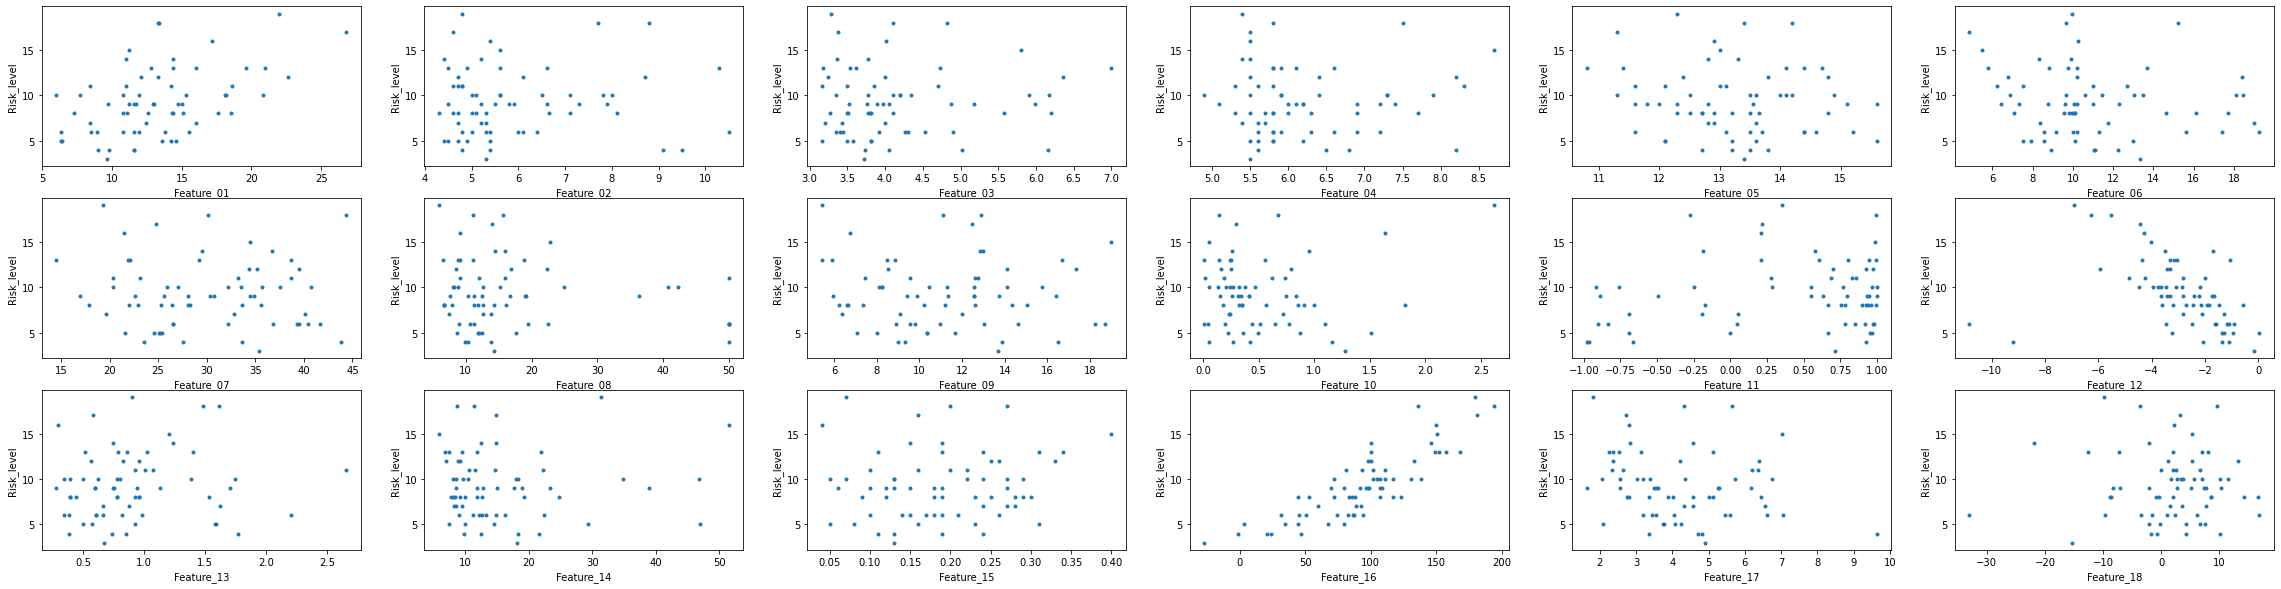

In [82]:
ncol = len(listColNames)//3 + len(listColNames)%3
fig, axs = plt.subplots(3, ncol, figsize=(40,10))
for Col in range(len(listColNames)):
    ax = axs[Col//ncol, Col%ncol]
    ax.plot(X[:,Col],Y[:],'.')
    ax.set_xlabel(listColNames[Col])
    ax.set_ylabel('Risk_level')

## QUESTION 2.1 : 
Observez les donnees unes par unes. Est-ce que vous identifiez visuellement des liens entre certaines variables et la variable 'Risk_level'. Si oui, lesquels ?

<span style="color:blue"> Il semblerait qu'il y ait un lien lineaire entre `Feature 12` et `Feature 16` et le `Risk Level`</span>

## QUESTION 2.2 :  On se demande si il est possible de predire le niveau de 'Risk_level' à partir d'une seule des variables 'Feature_01', 'Feature_07' ou 'Feature_16'.

### QUESTION 2.2.1 : 
Effectuez une regression lineaire simple entre `Risk_level` et chacune de ces variables. Toutes les donnees seront utilisees. 

Evaluez alors la qualité des predictions sur toutes les donnees à l'aide de __la moyenne de l'erreur de prediction au carre (MSE)__. 

Quel est le risque potentiel en utilisant cette stratégie de validation de l'apprentissage ?

- <span style="color:blue">On risque de sur-apprendre (over-fitting) sur ce jeu de données là et de ne pas avoir un modele assez générale.</span>

Feature_01, mse=10.480923895867484
Feature_07, mse=13.506926344682194
Feature_16, mse=3.8333467105730303


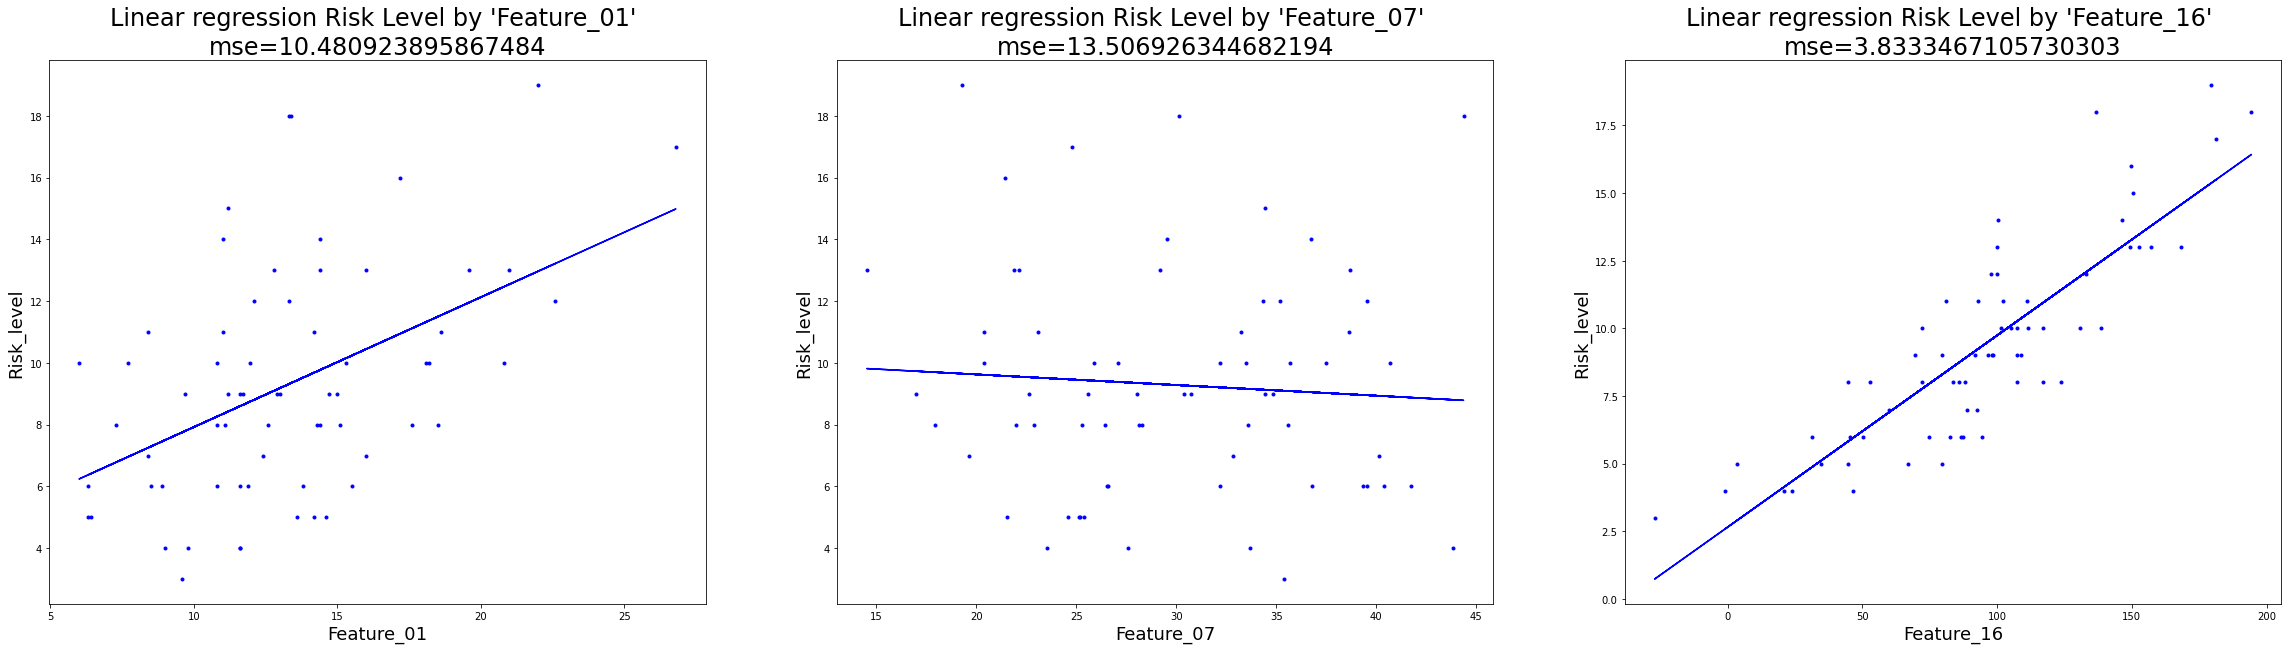

In [75]:
def linear_risk(X, Y, listColNames, colname, ax, bigger_font=False):
    col_index = listColNames.index(colname   )
    x = X[:, col_index]
    linear_reg(x, Y, colname, ax, bigger_font)

def linear_reg(x, y, colname, ax, bigger_font=False):
    lr = LinearRegression()
    lr.fit(x[:, np.newaxis], y)
    y_pred = lr.predict(x[:, np.newaxis])
    mse = mean_squared_error(y, y_pred)
    print(f"{colname}, {mse=}")
    ax.plot(x,y[:],'b.')
    ax.plot(x, y_pred, 'b-')
    label_fontsize = 18 if bigger_font else 12
    ax.set_xlabel(colname, fontsize=label_fontsize)
    ax.set_ylabel('Risk_level', fontsize=label_fontsize)
    title_fontsize = 24 if bigger_font else 12
    ax.set_title(f"Linear regression Risk Level by '{colname}' \n{mse=}", fontsize=title_fontsize)

pred_features = ['Feature_01','Feature_07','Feature_16']
fig, axs = plt.subplots(1, len(pred_features), figsize=(40,10))
for col_index, colname in enumerate(pred_features):
    linear_risk(X, Y, listColNames, colname, axs[col_index], bigger_font=True)

### QUESTION 2.2.2 : 
Evaluez a quel point les predictions sont stables a l'aide d'une methode de validation croisee
de type 4-folds.

In [19]:
n_splits = 4

kf = KFold(n_splits=n_splits)

for feature in [0, 6, 15]:
    sum_mse_scores=0.
    X_select = X[:, feature].reshape(-1,1)
    for train, test in kf.split(X):
        X_train=X_select[train]
        y_train=Y[train]
        X_test=X_select[test]
        y_test=Y[test]
        
        y_train.shape
        
        lr = LinearRegression()
        
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        mse_score = mean_squared_error(y_test, y_pred)
    
        sum_mse_scores += mse_score
    
    mean = sum_mse_scores/n_splits
    print('Pour la Feature ' + str(feature+1) + ', la MSE moyenne après 4-fold vaut ' + str(mean))

Pour la Feature 1, la MSE moyenne après 4-fold vaut 10.938813503318636
Pour la Feature 7, la MSE moyenne après 4-fold vaut 15.209387726987929
Pour la Feature 16, la MSE moyenne après 4-fold vaut 4.083669877334086


### QUESTION 2.2.3 : 

Peut-on enfin dire si on observe une relation significative entre 'Risk_level' et (independament) 'Feature_01', 'Feature_07' ou bien 'Feature_16'. 

On peut le valider a l'aide d'un test d'hypothese dont on decrira la procedure.

## QUESTION 2.3 :
On s'interesse maintenant au lien entre la variable 'Risk_level' et 'Feature_12'.
On peut remarquer que ces donnees contiennent deux valeurs aberrantes.

Feature_12, mse=11.285264479808852


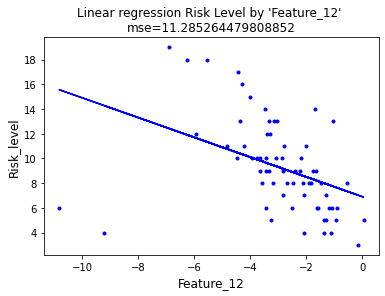

In [83]:
    Feature_12 = X[:, listColNames.index("Feature_12")]
    ax = plt.subplots()[1]
    linear_reg(Feature_12, Y, "Feature_12", ax)
    # there is clearly some outiers in 'Feature_12'

## QUESTION 2.3.1 : 
Definissez une procedure pour detecter automatiquement deux donnees aberrantes dans un jeu de donnees.

Detecting outliers in 'Feature_12' observations for predicting 'Risk_level'
	Outlier #0 is Observation #29 with D(29)=2.076921642023367
	Outlier #1 is Observation #49 with D(49)=1.212158061191167


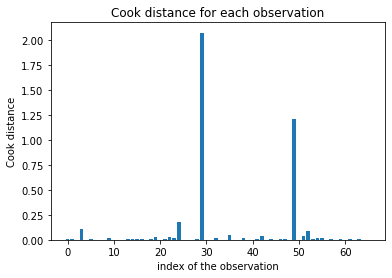

In [84]:
def lr_fit(x,y):
    lr = LinearRegression()
    lr.fit(x[:, np.newaxis], y)
    return lr

def cook_distances(x,y):
    n = len(x)
    lr = lr_fit(x,y)
    y_pred = lr.predict(x[:, np.newaxis])
    s2=np.sum((y-y_pred)*(y-y_pred))/(n-2)

    distances = []
    for i in range(n):
        x_del_i=np.delete(x,i)
        y_del_i=np.delete(y,i)
        lr_del_i = lr_fit(x_del_i, y_del_i)
        y_hat_pred = lr_del_i.predict(x[:, np.newaxis])

        sum_squared_error=np.sum((y_pred - y_hat_pred)*(y_pred - y_hat_pred))
        distances.append(sum_squared_error/(2.*s2))
    return distances

def detect_outliers(X, Y, nb_outliers=2):
    cookdistances = cook_distances(X,Y)
    plt.bar(list(range(len(cookdistances))), cookdistances)
    plt.title("Cook distance for each observation")
    plt.ylabel("Cook distance")
    plt.xlabel("index of the observation")

    cook_dict = {i: dist for i, dist in enumerate(cookdistances)}
    cook_dict_sorted = {k: v for k, v in sorted(cook_dict.items(), key=lambda item: item[1], reverse=True)}

    outliers = list(cook_dict_sorted.items())
    for i in range(nb_outliers):
        outlier = outliers[i]
        print(f"\tOutlier #{i} is Observation #{outlier[0]} with D({outlier[0]})={outlier[1]}")

    return cook_dict_sorted

def detect_outliers_df(df, xname="Feature_12", yname='Risk_level', nb_outliers=2):
    print(f"Detecting outliers in '{xname}' observations for predicting '{yname}'")
    return detect_outliers(df[xname].to_numpy(), df[yname].to_numpy(), nb_outliers)

outliers = detect_outliers_df(dataframe)

In [22]:
list(outliers.keys())[:2]

[29, 49]

## QUESTION 2.3.2 : 
Nous supprimerons dans la suite de cet exercice les deux observations qui sont aberrantes sur la variable 'Feature_12'. Comment auriez-vous traite ces observations si vous aviez absolument voulu preserver l'information qu'elles contiennent dans les autres variables ?

(66,) (66, 1)
(64,) (64, 1)
y = [-1.88491664]x + [4.22208744]
Feature_12, mse=5.84891423784936


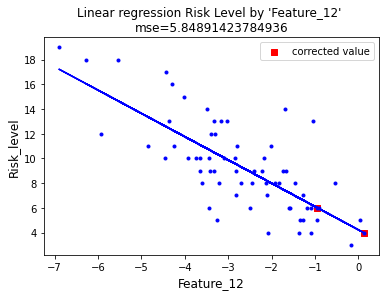

In [85]:
def delete_and_replace_outliers(x,y, indexes):
    xdel = np.array([v for i,v in enumerate(x) if i not in frozenset(indexes)])
    ydel = np.array([v for i,v in enumerate(y) if i not in frozenset(indexes)])
    
    print(x.shape, y.shape)
    print(xdel.shape, ydel.shape)
    
    lr_del = lr_fit(xdel, ydel)
    y_hat_pred = lr_del.predict(x[:, np.newaxis])
    a = lr_del.coef_[0]
    b =lr_del.intercept_
    print(f"y = {a}x + {b}")
    newx = np.array(x)
    for i in indexes:
        newx[i] = (y[i] -b)/a

    return x, newx

ax = plt.subplots()[1]
x, newx = delete_and_replace_outliers(Feature_12,Y, list(outliers.keys())[:2])

linear_reg(newx, Y, "Feature_12", ax)
xout = [newx[i] for i in list(outliers.keys())[:2]]
yout = [Y.flatten()[i] for i in list(outliers.keys())[:2]]
ax.scatter(xout, yout, c='red', marker='s', label='corrected value')
ax.legend()
# Much better now

## QUESTION 2.4 :
Une fois les deux observations aberrantes de 'Feature_12' supprimees, on souhaite selectionner les variables de 'X' qui permettent de prédire au mieux 'Risk_level' a l'aide de la regression multiple regularisee.

In [86]:
# TODO : Changer Y avec y_smoothed

display(dataframe.Feature_12[29])
dataframe.Feature_12.update(pd.Series(newx))
display(dataframe.Feature_12[29])

XY=dataframe.values
Y=XY[:,ColNb_Y].reshape((XY.shape[0],1))   #reshape is to make sure that Y is a column vector
X = np.delete(XY, ColNb_Y, 1)
print(X.shape)

-10.82853664

-0.943231397971216

(66, 18)


## QUESTION 2.4.1 : 
Quelle strategie vous semble la plus appropriee pour selectionner les variables les plus pertinentes ? 

Quel pretraitement allez-vous de meme effectuer sur les donnees.

La régression Lasso semble appropriée pour sélectionner les variables les plus pertinentes. Il va néanmoins falloir déterminer les coefficients alpha permettant la meilleure qualité de prédiction.


## QUESTION 2.4.2 : 
Effectuez la procedure de selection des variables optimales en parametrant a la main le poids entre la qualite de prediction et le niveau de regularisation.

In [56]:
n = len(X)
thresh=n // 2 #On coupe en 2 les données de test et apprentissage
X_train = X[thresh:]
y_train = Y[thresh:]
X_test = X[:thresh]
y_test = Y[:thresh]

for alpha in [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 100]:

    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X_train, y_train)

    y_pred_lasso = lasso_regressor.predict(X_test)
    mse_score_lasso = mean_squared_error(y_test, y_pred_lasso)
    R_2 = lasso_regressor.score(X_test, y_test)
    print('alpha = ' + str(alpha) + '; R_2 = ' + str(R_2))
    
#fig = plt.figure()
#plt.plot(y_test, y_pred_lasso, 'r.')
#plt.xlabel('True value')
#plt.ylabel('Predicted value')
#plt.title('True vs predicted value (mse='+str(mse_score_lasso)+')')
#plt.show()

alpha = 0.001; R_2 = 0.4898392416256351
alpha = 0.01; R_2 = 0.521139653279338
alpha = 0.1; R_2 = 0.5787797956614691
alpha = 0.5; R_2 = 0.6072821547450635
alpha = 1; R_2 = 0.5863589376083591
alpha = 5; R_2 = 0.5937517001702399
alpha = 10; R_2 = 0.5902824961979823
alpha = 20; R_2 = 0.5801597746411312
alpha = 100; R_2 = 0.3463309487941896


## QUESTION 2.4.3 : 
Effectuez la procedure automatique de parametrisation de ce poids, de sorte a ce q'un maximum de trois variables soit typiquement selectionne et que la qualite de prediction soit optimale.

Quelle methode de validation croisee vous semble la plus raisonnable ici ? 

La selection des variables est-elle stable ?